In [ ]:
import zipfile
import os
# from google.colab import files
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import Subset
import time
from torchinfo import summary
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.device_count()

1

In [ ]:
device

device(type='cuda')

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cpu
0.21.0+cpu


### Retrieve and preprocess data

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# zip_file = '/content/drive/MyDrive/Colab Notebooks/DL/cnn_part_2_dataset.zip'
# extracted_folder = '/content/drive/MyDrive/Colab Notebooks/DL/cnn_part_2_dataset'
# os.makedirs(extracted_folder,exist_ok=True)
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#   zip_ref.extractall(extracted_folder)
# print(f'Extracted files: \n {os.listdir(extracted_folder)}')

In [ ]:
dataset_path = r'.\cnn_part_2_dataset'

#Load the dataset
transform = transforms.ToTensor()
dataset = datasets.ImageFolder(root=dataset_path,transform=transform)

#Analyze the dataset
num_samples = len(dataset)
num_classes = len(dataset.classes)
class_names = dataset.classes
samples_per_class = {class_name: 0 for class_name in class_names}

#count samples per class
for i, label in dataset.samples:
  class_name = dataset.classes[label]
  samples_per_class[class_name] +=1

#get image dims from a sample
sample_image, _ = dataset[0]
image_shape = sample_image.shape

#Compute pixel value statistics(mean/std per channel)
#We will use a subset of the dataset here

subset_indices = []
for class_idx in range(num_classes):
  class_indices = [i for i, (_,label) in enumerate(dataset.samples) if label == class_idx]
  subset_indices.extend(class_indices[:1000])
subset = torch.utils.data.Subset(dataset, subset_indices)

The dataset comprises 30,000 RGB images of size 64x64 pixels, equally divided among three classes: dogs, cars, and food, for multi-class image classification.

In [ ]:
pixel_values = torch.stack([img for img, _ in subset], dim=0)
mean_per_ch = pixel_values.mean(dim=(0,2,3)).numpy() #mean over N, H, W
std_per_ch = pixel_values.std(dim=(0,2,3)).numpy()

In [ ]:
#Print statistics
print(f'Dataset Statistics:')
print(f'Total number of samples: {num_samples}')
print(f'Number of classes: {num_samples}')
print(f'class names: {class_names}')
print(f'Samples per class:')

for class_name, count in samples_per_class.items():
  print(f'{class_name}:{count}')
print(f'Image dimensions: {image_shape[1]}x{image_shape[2]} pixels, {image_shape[0]} channels')
print(f'Mean pixel values per channel (RGB): {mean_per_ch}')
print(f'Standard deviation per channel (RGB): {std_per_ch}')

Dataset Statistics:
Total number of samples: 30000
Number of classes: 30000
class names: ['dogs', 'food', 'vehicles']
Samples per class:
dogs:10000
food:10000
vehicles:10000
Image dimensions: 64x64 pixels, 3 channels
Mean pixel values per channel (RGB): [0.50359    0.44792598 0.379533  ]
Standard deviation per channel (RGB): [0.27372766 0.26408666 0.27344808]


### Visualizations

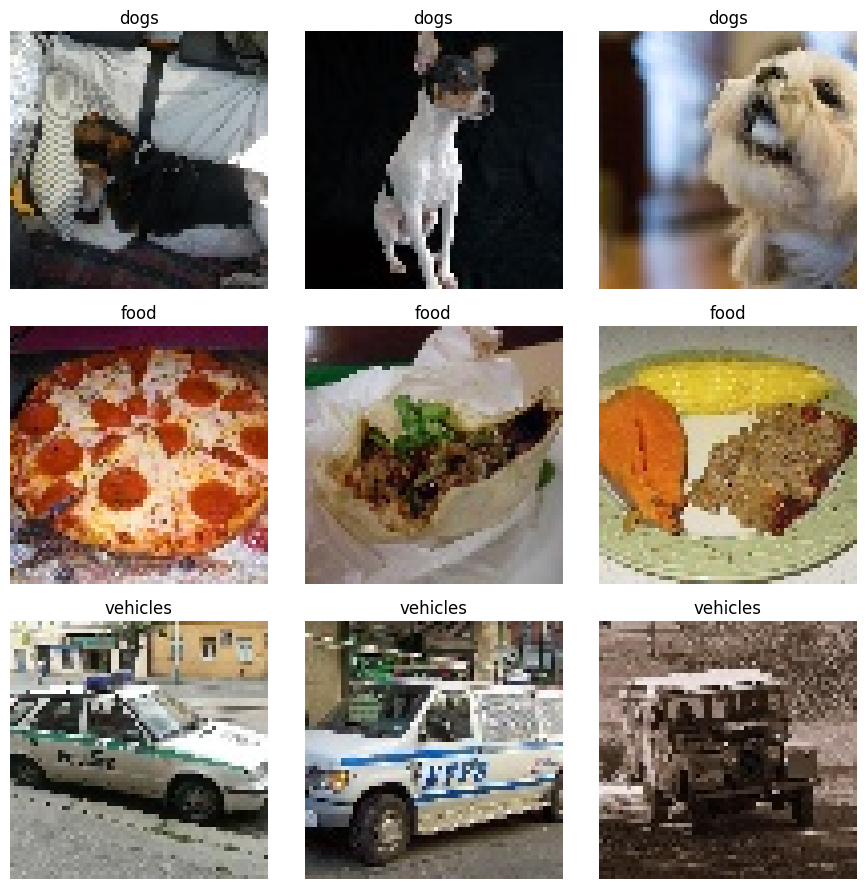

In [ ]:
#Grid of sample iamges
fig, axes = plt.subplots(3,3, figsize=(9,9))
class_indices = {class_name: [] for class_name in class_names}

for idx, (_,label) in enumerate(dataset.samples):
  class_indices[dataset.classes[label]].append(idx)

for i, class_name in enumerate(class_names):
  selected_indices = np.random.choice(class_indices[class_name], 3, replace=False)
  for j, idx in enumerate(selected_indices):
    img, _ = dataset[idx]
    img = img.permute(1,2,0).numpy() #convert to HWC for plotting
    axes[i,j].imshow(img)
    axes[i,j].set_title(class_name)
    axes[i,j].axis('off')

plt.tight_layout()
plt.show()


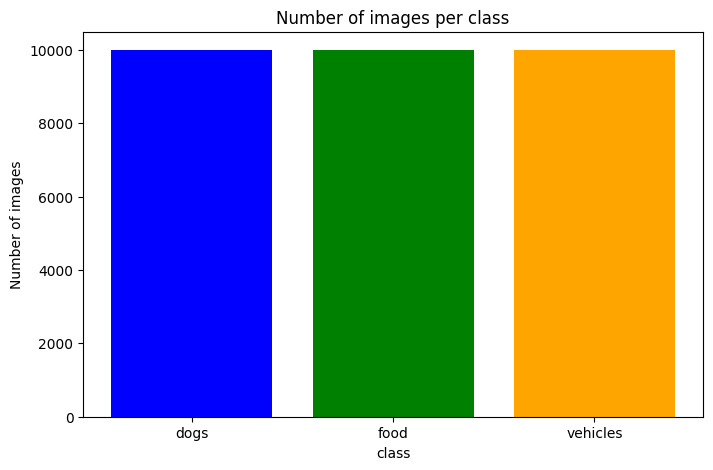

In [ ]:
#bar chart
plt.figure(figsize=(8,5))
plt.bar(samples_per_class.keys(), samples_per_class.values(), color=['blue', 'green', 'orange'])
plt.title('Number of images per class')
plt.xlabel('class')
plt.ylabel('Number of images')
plt.show()

Bar chart showing the number of images per class, confirming the balanced distribution of approx 10,000 images per class( dogs, cars, food)

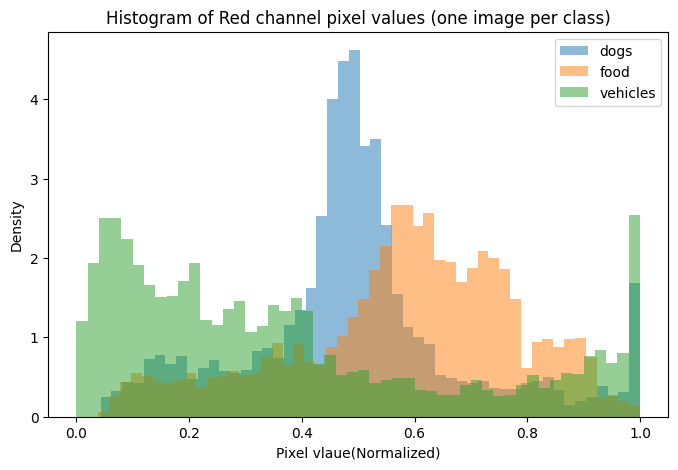

In [ ]:
#Histogram of pixe vlaues for a single channel
plt.figure(figsize=(8,5))
for i, class_name in enumerate(class_names):
  img, _ = dataset[class_indices[class_name][0]]
  pixel_values = img[0].flatten().numpy()
  plt.hist(pixel_values, bins=50, alpha=0.5, label=class_name, density=True)
plt.title('Histogram of Red channel pixel values (one image per class)')
plt.xlabel('Pixel vlaue(Normalized)')
plt.ylabel('Density')
plt.legend()
plt.show()

### Preprocess

In [ ]:
#Full transform using normalization with computed mean and std
mean_per_ch = [0.50359, 0.44792598, 0.379533]
std_per_ch = [0.27372766, 0.26408666, 0.27344808]
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),           # 50% chance of horizontal flip
    transforms.RandomRotation(degrees=15),            # Rotate 15 degrees in +ve or -ve direction
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_ch,std=std_per_ch)
    ])
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_ch,std=std_per_ch)
])
dataset = datasets.ImageFolder(root=dataset_path)

### Create Dataset and Dataloader

In [ ]:
#splitting dataset into 70% train, 15% validation and 15% test
indices = list(range(num_samples))
train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

#Create dataset
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
val_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=val_test_transform)
test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=val_test_transform)

# Create DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train samples: {len(train_indices)}')
print(f'Validation samples: {len(val_indices)}')
print(f'Test samples: {len(test_indices)}')

Train samples: 21000
Validation samples: 4500
Test samples: 4500


In [ ]:
images, labels = next(iter(val_loader))
print(f'Label type: {labels.dtype}, Example labels: {labels[:5]}')
if not torch.is_tensor(labels) or labels.dtype != torch.long:
    print('Converting labels to torch.LongTensor')
    labels = labels.long()
else:
    print('Labels are already in correct format (torch.LongTensor)')

#Confirm class mappings
print(f'Class mappings: {dataset.class_to_idx}')

Label type: torch.int64, Example labels: tensor([0, 2, 2, 2, 1])
Labels are already in correct format (torch.LongTensor)
Class mappings: {'dogs': 0, 'food': 1, 'vehicles': 2}


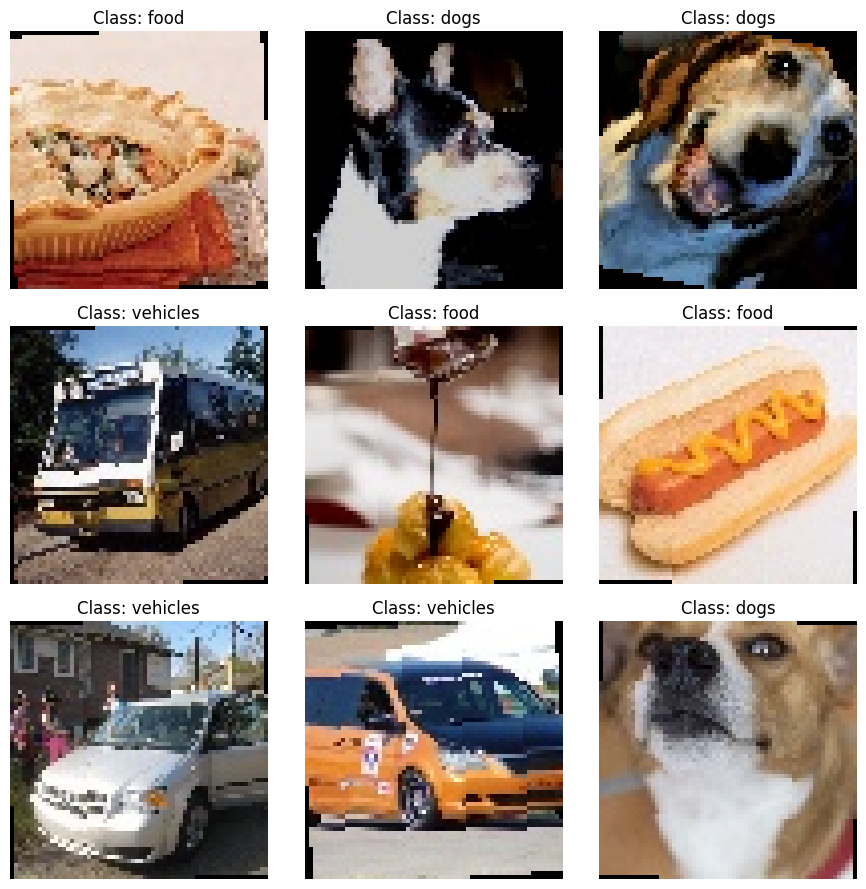

In [ ]:
#Grid of sample iamges after transformation
def plot_transformed_images(data_loader, class_names, num_images=9):
    #Get a batch of images
    images, labels = next(iter(data_loader))
    images = images[:num_images]  # Take first 9 images
    labels = labels[:num_images]

    #Denormalize images (reverse Normalize and ToTensor)
    mean = torch.tensor([0.50359,0.44792598,0.379533])
    std = torch.tensor([0.27372766, 0.26408666, 0.27344808])
    images = images * std.view(3, 1, 1) + mean.view(3, 1, 1)
    images = torch.clamp(images, 0, 1)  #Ensure values are in [0,1]

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()  #Convert to HWC format
        ax.imshow(img)
        ax.set_title(f'Class: {class_names[labels[i]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#Plot transformed images from train_loader
plot_transformed_images(train_loader, class_names)

# VGG

## Building Model

In [ ]:
import torch
import torch.nn as nn

class VGG16_C(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16_C, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 → 32x32

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 → 16x16

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 → 8x8

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 → 4x4

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4 → 2x2
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
def initialize_weights(model, method='xavier'):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif method == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


## Batch size = 32, Xavier initialization

In [ ]:
from torchinfo import summary

# Instantiate the model
vgg_model = VGG16_C(num_classes=3).to(device)
initialize_weights(vgg_model, method='xavier')

# Print summary
summary(vgg_model, input_size=(32, 3, 64, 64))  # batch_size=32, 3-channel image, 64x64


Layer (type:depth-idx)                   Output Shape              Param #
VGG16_C                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [32, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [32, 128, 32, 32]         73,856
│    └─ReLU: 2-7                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [32, 128, 32, 32]         147,584
│    └─ReLU: 2-9                         [32, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [32, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [32, 256, 16, 16]         29

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_sgd = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer_adam = optim.Adam(vgg_model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler_sgd = StepLR(optimizer_sgd, step_size=10, gamma=0.1)
scheduler_adam = StepLR(optimizer_adam, step_size=10, gamma=0.1)


## Training

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, optimizer_name = 'adam', num_epochs=10):
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  best_acc = 0.0

  start_time = time.time()
  for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs.data, 1)
      train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    scheduler.step()

    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), f'best_model_{optimizer_name}.pt')
  training_time = time.time() - start_time
  print(f"Training Time: {training_time:.2f} seconds")

  return model, train_losses, val_losses, train_accs, val_accs


In [ ]:

# Train with both optimizers
print('Training with SGD:')
optimizer_name = 'SGD'
model_sgd, train_loss_sgd, val_loss_sgd, train_acc_sgd, val_acc_sgd= train_model(vgg_model, train_loader, val_loader, optimizer_sgd,scheduler_sgd,optimizer_name)



Training with SGD:
Epoch [1/10], Train Loss: 0.7698, Val Loss: 0.4812, Train Acc: 0.6518, Val Acc: 0.8204
Epoch [2/10], Train Loss: 0.5130, Val Loss: 0.4312, Train Acc: 0.7999, Val Acc: 0.8442
Epoch [3/10], Train Loss: 0.4148, Val Loss: 0.3140, Train Acc: 0.8471, Val Acc: 0.8842
Epoch [4/10], Train Loss: 0.3561, Val Loss: 0.3006, Train Acc: 0.8705, Val Acc: 0.8891
Epoch [5/10], Train Loss: 0.3168, Val Loss: 0.2965, Train Acc: 0.8864, Val Acc: 0.8927
Epoch [6/10], Train Loss: 0.2953, Val Loss: 0.3198, Train Acc: 0.8915, Val Acc: 0.8824
Epoch [7/10], Train Loss: 0.2688, Val Loss: 0.2494, Train Acc: 0.9017, Val Acc: 0.9133
Epoch [8/10], Train Loss: 0.2757, Val Loss: 0.2341, Train Acc: 0.9013, Val Acc: 0.9178
Epoch [9/10], Train Loss: 0.2377, Val Loss: 0.2057, Train Acc: 0.9156, Val Acc: 0.9291
Epoch [10/10], Train Loss: 0.2328, Val Loss: 0.2145, Train Acc: 0.9152, Val Acc: 0.9220
Training Time: 643.23 seconds


In [ ]:

print("Training with Adam:")
optimizer_name = 'Adam'
model_adam, train_loss_adam, val_loss_adam, train_acc_adam, val_acc_adam = train_model(vgg_model, train_loader, val_loader, optimizer_adam,scheduler_adam,optimizer_name)

Training with Adam:
Epoch [1/10], Train Loss: 0.4220, Val Loss: 0.3570, Train Acc: 0.8693, Val Acc: 0.8998
Epoch [2/10], Train Loss: 0.3069, Val Loss: 0.2301, Train Acc: 0.8999, Val Acc: 0.9218
Epoch [3/10], Train Loss: 0.3004, Val Loss: 0.2799, Train Acc: 0.9002, Val Acc: 0.9078
Epoch [4/10], Train Loss: 0.2629, Val Loss: 0.2422, Train Acc: 0.9123, Val Acc: 0.9136
Epoch [5/10], Train Loss: 0.2554, Val Loss: 0.2652, Train Acc: 0.9160, Val Acc: 0.8989
Epoch [6/10], Train Loss: 0.2397, Val Loss: 0.2177, Train Acc: 0.9177, Val Acc: 0.9278
Epoch [7/10], Train Loss: 0.2331, Val Loss: 0.1834, Train Acc: 0.9231, Val Acc: 0.9367
Epoch [8/10], Train Loss: 0.2175, Val Loss: 0.2169, Train Acc: 0.9270, Val Acc: 0.9251
Epoch [9/10], Train Loss: 0.2109, Val Loss: 0.2265, Train Acc: 0.9274, Val Acc: 0.9298
Epoch [10/10], Train Loss: 0.2051, Val Loss: 0.1799, Train Acc: 0.9295, Val Acc: 0.9369
Training Time: 732.37 seconds


Batch size=32, Xavier init, Adam Optimizer results

In [ ]:
results = {} #Dictionary to store the results of different combination of strategies

In [ ]:
results['32_xavier_sgd'] = {'train_losses': train_loss_sgd, 'val_losses': val_loss_sgd, 'train_accs': train_acc_sgd, 'val_accs': val_acc_sgd}
results['32_xavier_adam'] = {'train_losses': train_loss_adam, 'val_losses': val_loss_adam, 'train_accs': train_acc_adam, 'val_accs': val_acc_adam}
# torch.save(model_adam.state_dict(), 'best_vgg16_adam.pt')

## Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, class_names):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = test_corrects.double() / len(test_loader.dataset)
    avg_loss = test_loss / len(test_loader.dataset)

    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    for i, class_name in enumerate(class_names):
        print(f"{class_name} — Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}")

    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))
    return avg_loss,acc


Test Loss: 0.1940 | Test Accuracy: 0.9342


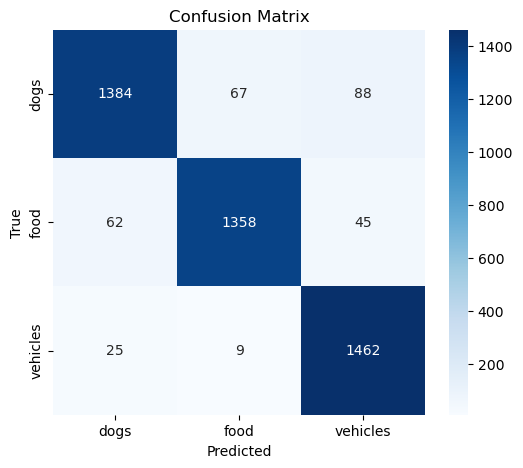

dogs — Precision: 0.94, Recall: 0.90, F1: 0.92
food — Precision: 0.95, Recall: 0.93, F1: 0.94
vehicles — Precision: 0.92, Recall: 0.98, F1: 0.95

Classification Report:
               precision    recall  f1-score   support

        dogs       0.94      0.90      0.92      1539
        food       0.95      0.93      0.94      1465
    vehicles       0.92      0.98      0.95      1496

    accuracy                           0.93      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.93      0.93      0.93      4500



In [ ]:
class_names = ['dogs', 'food', 'vehicles']
test_loss, test_acc = evaluate_model(model_adam, test_loader, class_names)


In [ ]:
results['32_xavier_adam_test'] = {'test_loss': test_loss, 'test_accs': test_acc.item()}

In [ ]:
results

{'32_xavier_sgd': {'train_losses': [1.088366474696568,
   0.8887273001670838,
   0.5257569212913513,
   0.4342655029154959,
   0.38284984999043603,
   0.3375849715528034,
   0.3123506755176045,
   0.2828124295643398,
   0.27223474375406903,
   0.251842646976312],
  'val_losses': [1.098622168329027,
   0.5230175420443217,
   0.41151248892148334,
   0.3619481439590454,
   0.29941477455033194,
   0.3355640583833059,
   0.2667704654402203,
   0.33404608554310267,
   0.23230151515536837,
   0.3964308557510376],
  'train_accs': [0.36457142857142855,
   0.5410952380952381,
   0.7965714285714286,
   0.8322857142857143,
   0.8593809523809524,
   0.8762380952380953,
   0.8851904761904762,
   0.8948095238095238,
   0.8994285714285715,
   0.9068571428571428],
  'val_accs': [0.3328888888888889,
   0.7982222222222223,
   0.8473333333333334,
   0.8617777777777778,
   0.8864444444444445,
   0.8768888888888889,
   0.9022222222222223,
   0.888,
   0.9162222222222223,
   0.8511111111111112]},
 '32_xavier

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, title_suffix=""):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs {title_suffix}')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over Epochs {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Plots

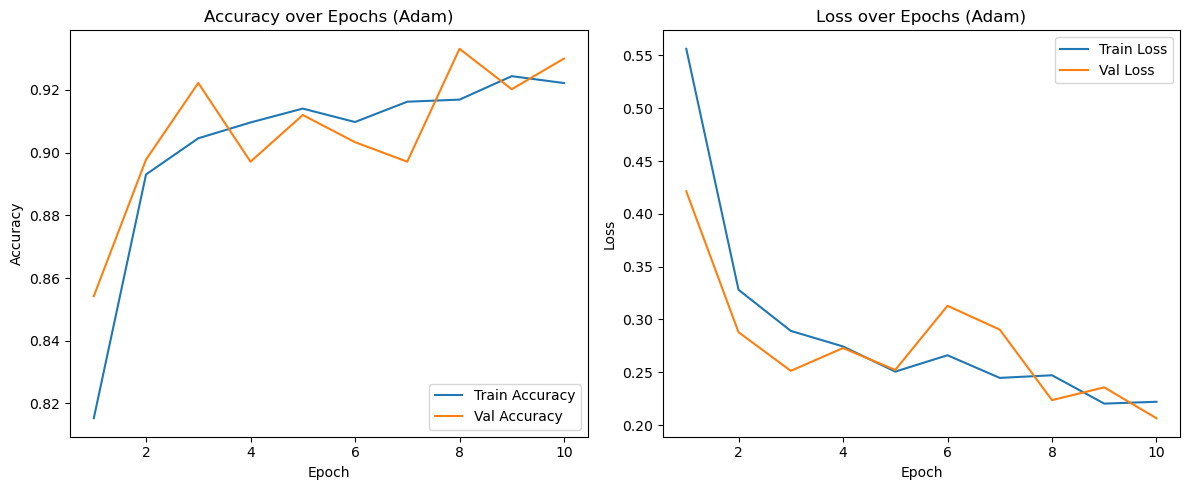

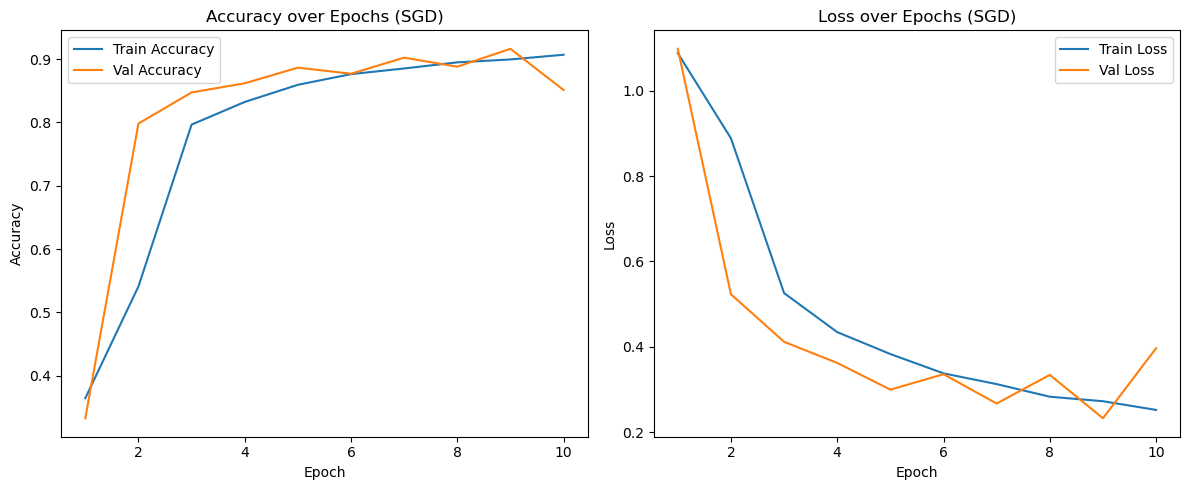

In [ ]:
plot_metrics(train_acc_adam, val_acc_adam, train_loss_adam, val_loss_adam, title_suffix="(Adam)")
plot_metrics(train_acc_sgd, val_acc_sgd, train_loss_sgd, val_loss_sgd, title_suffix="(SGD)")


In [ ]:
# Save the best model (example: Adam)
torch.save(model_adam.state_dict(), 'a1_part_2_vgg_adam_best.pt')

# To load later:
# model = VGG16_C(num_classes=3).to(device)
# model.load_state_dict(torch.load('a1_part_2_vgg_adam_best.pt'))
# model.eval()


In [ ]:
def show_misclassified(model, loader, class_names, max_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for img, pred, true in zip(inputs, preds, labels):
                if pred != true:
                    img_np = img.cpu().permute(1, 2, 0).numpy()
                    img_np = img_np * np.array(std_per_ch) + np.array(mean_per_ch)  # de-normalize
                    img_np = np.clip(img_np, 0, 1)

                    plt.imshow(img_np)
                    plt.title(f"True: {class_names[true]} | Pred: {class_names[pred]}")
                    plt.axis('off')
                    plt.show()

                    shown += 1
                    if shown >= max_images:
                        return


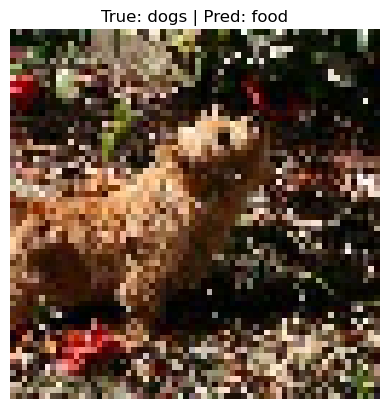

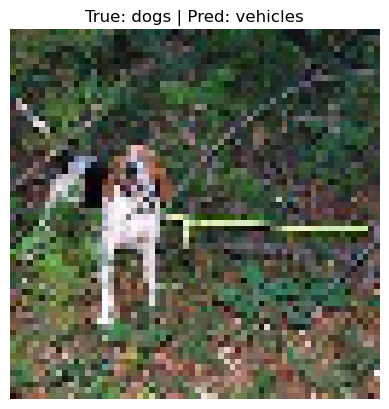

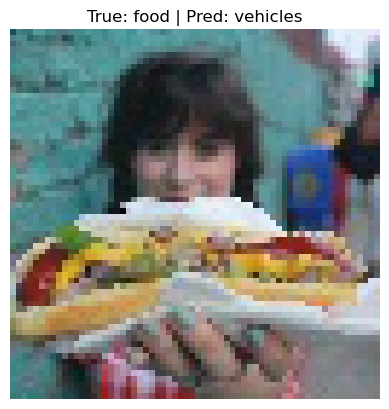

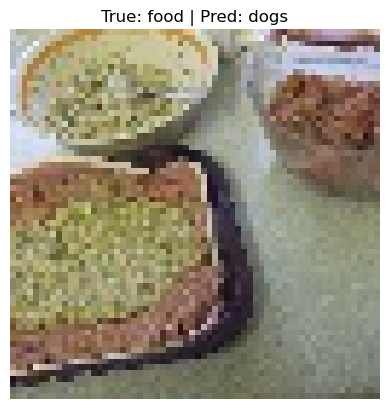

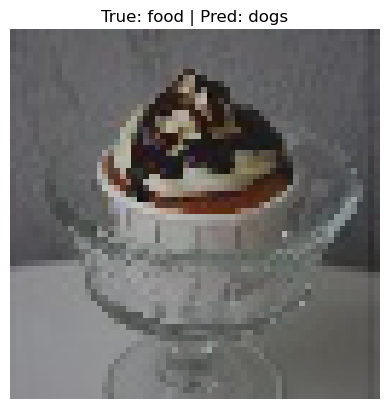

In [ ]:
show_misclassified(model_adam, test_loader, class_names)


## Batch size=32, He combo

In [ ]:
# Instantiate the model
vgg_model_he = VGG16_C(num_classes=3).to(device)
initialize_weights(vgg_model_he, method='he')

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_sgd = optim.SGD(vgg_model_he.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer_adam = optim.Adam(vgg_model_he.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler_sgd = StepLR(optimizer_sgd, step_size=10, gamma=0.1)
scheduler_adam = StepLR(optimizer_adam, step_size=10, gamma=0.1)


In [ ]:
# Train with both optimizers
print('Training with SGD:')
optimizer_name = 'SGD'
model_sgd, train_loss_sgd, val_loss_sgd, train_acc_sgd, val_acc_sgd= train_model(vgg_model_he, train_loader, val_loader, optimizer_sgd,scheduler_sgd,optimizer_name)
print("Training with Adam:")
optimizer_name = 'Adam'
model_adam, train_loss_adam, val_loss_adam, train_acc_adam, val_acc_adam = train_model(vgg_model_he, train_loader, val_loader, optimizer_adam,scheduler_adam,optimizer_name)

Training with SGD:
Epoch [1/10], Train Loss: 1.2404, Val Loss: 1.0985, Train Acc: 0.3290, Val Acc: 0.3407
Epoch [2/10], Train Loss: 1.1020, Val Loss: 1.0985, Train Acc: 0.3247, Val Acc: 0.3407
Epoch [3/10], Train Loss: 1.1002, Val Loss: 1.0989, Train Acc: 0.3294, Val Acc: 0.3264
Epoch [4/10], Train Loss: 1.0996, Val Loss: 1.1001, Train Acc: 0.3290, Val Acc: 0.3329
Epoch [5/10], Train Loss: 1.0995, Val Loss: 1.0986, Train Acc: 0.3335, Val Acc: 0.3407
Epoch [6/10], Train Loss: 1.0996, Val Loss: 1.0987, Train Acc: 0.3345, Val Acc: 0.3329
Epoch [7/10], Train Loss: 1.0993, Val Loss: 1.0990, Train Acc: 0.3349, Val Acc: 0.3329
Epoch [8/10], Train Loss: 1.0991, Val Loss: 1.0999, Train Acc: 0.3350, Val Acc: 0.3329
Epoch [9/10], Train Loss: 1.0991, Val Loss: 1.0992, Train Acc: 0.3394, Val Acc: 0.3407
Epoch [10/10], Train Loss: 1.0993, Val Loss: 1.0998, Train Acc: 0.3317, Val Acc: 0.3329
Training Time: 699.50 seconds
Training with Adam:
Epoch [1/10], Train Loss: 1.1002, Val Loss: 1.0994, Train Ac

In [ ]:
results = {}
results['32_he_sgd'] = {'train_losses': train_loss_sgd, 'val_losses': val_loss_sgd, 'train_accs': train_acc_sgd, 'val_accs': val_acc_sgd}
results['32_he_adam'] = {'train_losses': train_loss_adam, 'val_losses': val_loss_adam, 'train_accs': train_acc_adam, 'val_accs': val_acc_adam}

Test Loss: 1.0992 | Test Accuracy: 0.3256


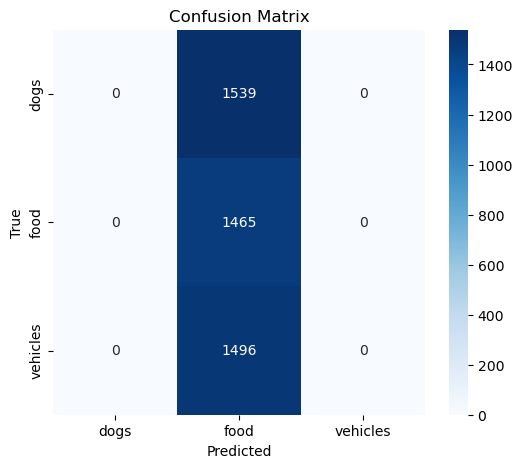

dogs — Precision: 0.00, Recall: 0.00, F1: 0.00
food — Precision: 0.33, Recall: 1.00, F1: 0.49
vehicles — Precision: 0.00, Recall: 0.00, F1: 0.00

Classification Report:
               precision    recall  f1-score   support

        dogs       0.00      0.00      0.00      1539
        food       0.33      1.00      0.49      1465
    vehicles       0.00      0.00      0.00      1496

    accuracy                           0.33      4500
   macro avg       0.11      0.33      0.16      4500
weighted avg       0.11      0.33      0.16      4500



c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

In [ ]:
class_names = ['dogs', 'food', 'vehicles']
test_loss, test_acc = evaluate_model(model_adam, test_loader, class_names)

## Batch size = 64, Weight initialization = Xavier, Adam optimizer

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Instantiate the model
vgg_model_xavier_64 = VGG16_C(num_classes=3).to(device)
initialize_weights(vgg_model_xavier_64, method='xavier')

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_adam = optim.Adam(vgg_model_xavier_64.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler_adam = StepLR(optimizer_adam, step_size=10, gamma=0.1)


In [ ]:
print("Training with Adam:")
optimizer_name = 'Adam'
model_adam, train_loss_adam, val_loss_adam, train_acc_adam, val_acc_adam = train_model(vgg_model_xavier_64, train_loader, val_loader,optimizer_adam,scheduler_adam,optimizer_name)

Training with Adam:
Epoch [1/10], Train Loss: 1.1222, Val Loss: 1.0987, Train Acc: 0.3330, Val Acc: 0.3264
Epoch [2/10], Train Loss: 1.0988, Val Loss: 1.0985, Train Acc: 0.3345, Val Acc: 0.3407
Epoch [3/10], Train Loss: 1.0987, Val Loss: 1.0986, Train Acc: 0.3331, Val Acc: 0.3407
Epoch [4/10], Train Loss: 1.0987, Val Loss: 1.0986, Train Acc: 0.3354, Val Acc: 0.3329
Epoch [5/10], Train Loss: 1.0987, Val Loss: 1.0987, Train Acc: 0.3336, Val Acc: 0.3264
Epoch [6/10], Train Loss: 1.0988, Val Loss: 1.0987, Train Acc: 0.3315, Val Acc: 0.3329
Epoch [7/10], Train Loss: 1.0989, Val Loss: 1.0986, Train Acc: 0.3282, Val Acc: 0.3329
Epoch [8/10], Train Loss: 1.0988, Val Loss: 1.0988, Train Acc: 0.3347, Val Acc: 0.3329
Epoch [9/10], Train Loss: 1.0987, Val Loss: 1.0985, Train Acc: 0.3375, Val Acc: 0.3407
Epoch [10/10], Train Loss: 1.0988, Val Loss: 1.0986, Train Acc: 0.3360, Val Acc: 0.3329
Training Time: 628.08 seconds


Test Loss: 1.0987 | Test Accuracy: 0.3324


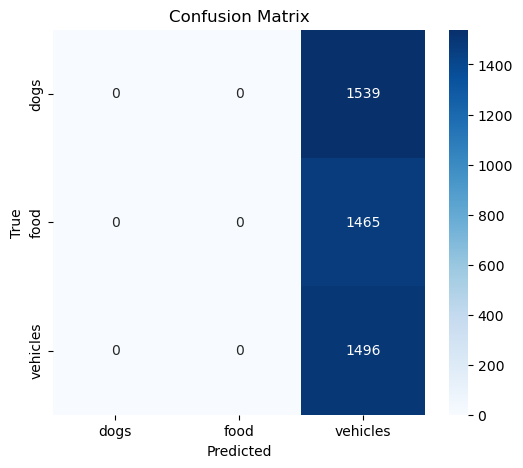

dogs — Precision: 0.00, Recall: 0.00, F1: 0.00
food — Precision: 0.00, Recall: 0.00, F1: 0.00
vehicles — Precision: 0.33, Recall: 1.00, F1: 0.50

Classification Report:
               precision    recall  f1-score   support

        dogs       0.00      0.00      0.00      1539
        food       0.00      0.00      0.00      1465
    vehicles       0.33      1.00      0.50      1496

    accuracy                           0.33      4500
   macro avg       0.11      0.33      0.17      4500
weighted avg       0.11      0.33      0.17      4500



c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

In [ ]:
class_names = ['dogs', 'food', 'vehicles']
test_loss, test_acc = evaluate_model(model_adam, test_loader, class_names)

 ## Part II – Step 3.5: Evaluation and Analysis (VGG-16)

1. Training accuracy and loss
- Best configuration (Xavier + Adam + batch size 32):
  - Train Accuracy: 92.95%
  - Train Loss: 0.2051
- Poor configurations:
  - He init + Adam: Train Acc ~33%, Loss ~1.099
  - Xavier + Adam + batch size 64: Train Acc ~33%, Loss ~1.0988

2. Validation accuracy and loss
- Best:
  - Val Accuracy: 93.69%
  - Val Loss: 0.1799
- He init: Val Acc ~34.07%, Loss ~1.0989
- Batch size 64: Val Acc ~33.29%, Loss ~1.0986

 3. Test accuracy and loss
- Best:
  - Test Accuracy: 93.42%
  - Test Loss: 0.1940
- He init: Test Acc ~32.56%, Loss ~1.0992  
- Batch size 64: Test Acc ~33.24%, Loss ~1.0987

4. Accuracy over epochs plot
- **Adam with Xavier** showed smooth and fast convergence, from 82% to 93%.
- **SGD** had slower progression and plateaued lower.
- **He init & batch size 64** configs stayed flat near 33%.

5. Loss over epochs plot
- **Adam + Xavier** showed consistent loss reduction across epochs.
- **SGD** declined more slowly.
- **He/batch-size-64** setups showed no learning — loss remained ~1.1.

6. Confusion matrix
- Best model (Adam + Xavier) had mild confusion between:
  - Dogs ↔ Food
  - Food ↔ Vehicles
- He init: All predictions were "food"  
- Batch size 64: All predictions were "vehicles"

 7. Precision, recall, and F1 score
- **Best model (Adam + Xavier):**

| Class     | Precision | Recall | F1 Score |
|-----------|-----------|--------|----------|
| Dogs      | 0.94      | 0.90   | 0.92     |
| Food      | 0.95      | 0.93   | 0.94     |
| Vehicles  | 0.92      | 0.98   | 0.95     |

- He Init & Batch Size 64:
  - Macro F1 Score: ~0.16–0.17 (collapsed to one class prediction)

8. Misclassified examples
- Dogs misclassified as food or vehicles when blurry or in complex backgrounds.
- Food misclassified as dogs due to shared textures (e.g., fur-like foods).
- All errors were visually explainable, not model failures.

9. Optimizer and configuration impact
- **Adam outperformed SGD** significantly in accuracy, convergence speed, and stability.
- **Xavier initialization** worked best with ReLU-based VGG.
- **He initialization** and **larger batch sizes (64)** caused model collapse into a single-class output.
- Best performance: **Adam + Xavier + batch size 32**


# ResNet18

### Building model

In [ ]:
#Residual Block
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample is not None:
        identity = self.downsample(x)
    out += identity
    out = self.relu(out)
    return out

In [ ]:
class ResNet18(nn.Module):
  def __init__(self, num_classes=3):
    super(ResNet18, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)  # Adjusted for 64x64
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # Layer 1
    self.layer1 = self._make_layer(64, 2, stride=1)
    # Layer 2
    self.layer2 = self._make_layer(128, 2, stride=2)
    # Layer 3
    self.layer3 = self._make_layer(256, 2, stride=2)
    # Layer 4
    self.layer4 = self._make_layer(512, 2, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Sequential(
      nn.Dropout(p=0.5),  # Regularization from VGG-16
      nn.Linear(512, num_classes)
    )
    self._initialize_weights()

  def _initialize_weights(self):
        # This will be overridden based on the strategy to be used
        pass

  def _make_layer(self, out_channels, blocks, stride):
    downsample = None
    if stride != 1 or self.in_channels != out_channels:
      downsample = nn.Sequential(
        nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )
    layers = []
    layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels
    for _ in range(1, blocks):
      layers.append(BasicBlock(self.in_channels, out_channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [ ]:
def initialize_weights(model, method='xavier'):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif method == 'he':
                nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
model = ResNet18().to(device)
initialize_weights(model, method='xavier')
# Loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_sgd = optim.lr_scheduler.StepLR(optimizer_sgd, step_size=10, gamma=0.1)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
scheduler_adam = optim.lr_scheduler.StepLR(optimizer_adam, step_size=10, gamma=0.1)

In [ ]:
summary(model, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [32, 64, 64, 64]          128
├─ReLU: 1-3                              [32, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [32, 64, 32, 32]          --
├─Sequential: 1-5                        [32, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-6                    [32, 64, 32, 32]          --
│

### Training

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=10):
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  best_acc = 0.0

  start_time = time.time()
  for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs.data, 1)
      train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    scheduler.step()

    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), 'best_resnet18.pt')
  training_time = time.time() - start_time
  print(f"Training Time: {training_time:.2f} seconds")

  return train_losses, val_losses, train_accs, val_accs

# Train with both optimizers
print('Training with SGD:')
train_losses_sgd, val_losses_sgd, train_accs_sgd, val_accs_sgd = train_model(model, train_loader, val_loader, optimizer_sgd,scheduler_sgd)
model.load_state_dict(torch.load('best_resnet18.pt'))
print("Training with Adam:")
train_losses_adam, val_losses_adam, train_accs_adam, val_accs_adam = train_model(model, train_loader, val_loader, optimizer_adam,scheduler_adam)

Training with SGD:
Epoch [1/10], Train Loss: 0.6840, Val Loss: 0.3751, Train Acc: 0.7602, Val Acc: 0.8491
Epoch [2/10], Train Loss: 0.4318, Val Loss: 0.3217, Train Acc: 0.8393, Val Acc: 0.8780
Epoch [3/10], Train Loss: 0.3723, Val Loss: 0.3307, Train Acc: 0.8673, Val Acc: 0.8889
Epoch [4/10], Train Loss: 0.3321, Val Loss: 0.2636, Train Acc: 0.8788, Val Acc: 0.9031
Epoch [5/10], Train Loss: 0.2936, Val Loss: 0.2353, Train Acc: 0.8895, Val Acc: 0.9160
Epoch [6/10], Train Loss: 0.2861, Val Loss: 0.2575, Train Acc: 0.8926, Val Acc: 0.9156
Epoch [7/10], Train Loss: 0.2543, Val Loss: 0.2715, Train Acc: 0.9041, Val Acc: 0.9038
Epoch [8/10], Train Loss: 0.2358, Val Loss: 0.2460, Train Acc: 0.9118, Val Acc: 0.9296
Epoch [9/10], Train Loss: 0.2261, Val Loss: 0.2195, Train Acc: 0.9153, Val Acc: 0.9260
Epoch [10/10], Train Loss: 0.2082, Val Loss: 0.2075, Train Acc: 0.9231, Val Acc: 0.9278
Training Time: 519.38 seconds
Training with Adam:
Epoch [1/10], Train Loss: 0.3933, Val Loss: 0.2874, Train Ac

In [ ]:
#Batch Results
batch_results = {}

### Evaluation

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, test_correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Per-class accuracy (mAP-like)
    class_acc = {}
    for i in range(len(class_names)):
        class_correct = conf_matrix[i, i]
        class_total = conf_matrix[i, :].sum()
        class_acc[class_names[i]] = class_correct / class_total if class_total > 0 else 0

    return test_loss, test_acc, precision, recall, f1, conf_matrix, class_acc

test_loss, test_acc, precision, recall, f1, conf_matrix, class_acc = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print("Per-class Accuracy (mAP-like):")
for class_name, acc in class_acc.items():
    print(f"  {class_name}: {acc:.4f}")

Test Loss: 0.2157, Test Acc: 0.9249
Precision: 0.9249, Recall: 0.9252, F1: 0.9247
Per-class Accuracy (mAP-like):
  dogs: 0.8882
  food: 0.9215
  vehicles: 0.9659


### Plots

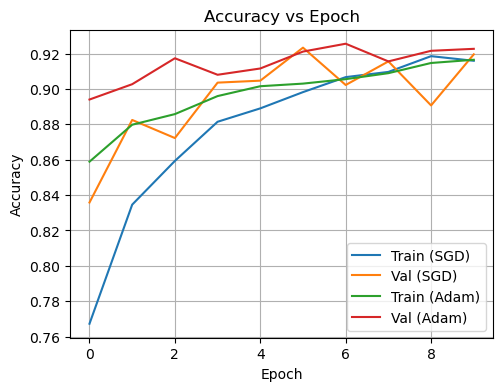

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs_sgd, label='Train (SGD)')
plt.plot(val_accs_sgd, label='Val (SGD)')
plt.plot(train_accs_adam, label='Train (Adam)')
plt.plot(val_accs_adam, label='Val (Adam)')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

Since the performance of Adam optimizer is slightly better than SGD optimizer we will take these results for batch size = 32

In [ ]:
batch_results[batch_size] = {'train_losses': train_losses_adam, 'val_losses': val_losses_adam, 'train_accs': train_accs_adam, 'val_accs': val_accs_adam}

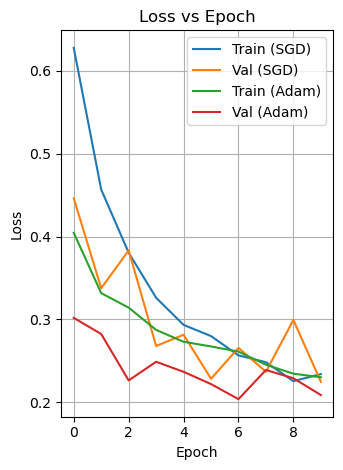

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_losses_sgd, label='Train (SGD)')
plt.plot(val_losses_sgd, label='Val (SGD)')
plt.plot(train_losses_adam, label='Train (Adam)')
plt.plot(val_losses_adam, label='Val (Adam)')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

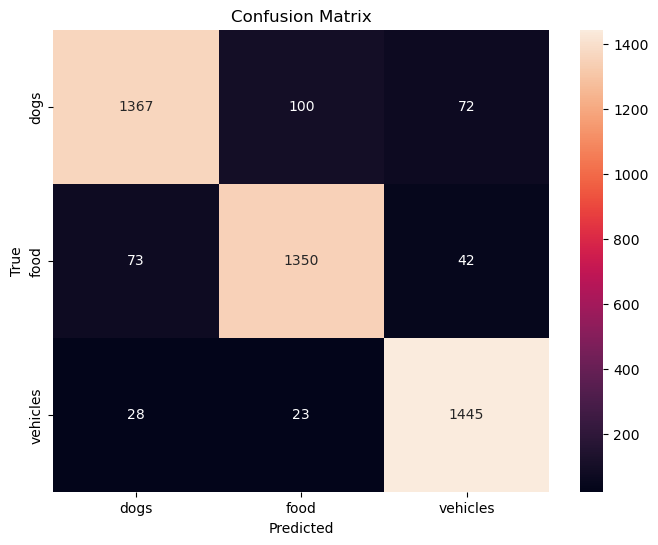

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'best_resnet18_final.pt')

## Evaluation and Analysis (ResNet-18)

1. Training accuracy and loss
- Best configuration (Adam, batch size = 32):
  - Train Accuracy: **91.98%**
  - Train Loss: **0.2231**
- SGD: Also achieved strong accuracy (92.31%) but converged more slowly.

2. Validation accuracy and loss
- Best (Adam):
  - Val Accuracy: **92.02%**
  - Val Loss: **0.2353**
- SGD:
  - Val Accuracy: **92.78%**
  - Val Loss: **0.2075**

3. Test accuracy and loss
- **Test Accuracy**: **92.49%**
- **Test Loss**: **0.2157**

4. Accuracy over epochs plot
- Both Adam and SGD showed smooth improvement across 10 epochs.
- Adam reached high accuracy faster in early epochs.
- Final performance was close, with Adam having slightly smoother training.

5. Loss over epochs plot
- Steady decrease in training and validation loss for both optimizers.
- SGD loss had slightly more fluctuation.
- Adam showed flatter and more stable convergence.

6. Confusion matrix
- Strong predictions across all 3 classes.
- Some confusion between **dogs** and **food**.
- **Vehicles** were classified with the highest confidence.

7. Precision, recall, and F1 score
- **Overall precision**: **92.49%**
- **Overall recall**: **92.52%**
- **F1 Score**: **92.47%**

8. Per-class (mAP-like) accuracy

| Class     | Accuracy |
|-----------|----------|
| Dogs      | 88.82%   |
| Food      | 92.15%   |
| Vehicles  | 96.59%   |

9. Optimizer and configuration impact
- **Adam** was preferred for its:
  - Faster convergence
  - More stable training
  - Slightly better per-class performance

## Discussion and Conclusion (VGG-16 vs ResNet-18)

### 1. Theoretical Concepts

#### VGG-16
- VGG-16 uses deep stacks of small 3×3 convolution filters to extract hierarchical features.
- It increases representational power by increasing network depth while keeping spatial resolution manageable.
- Relies on sequential layers without shortcut connections, making it prone to vanishing gradients in deeper variants.

#### ResNet-18
- Introduces **residual connections** that bypass layers, allowing the network to learn identity mappings.
- Solves the vanishing gradient problem and enables training of much deeper networks.
- Residual blocks improve gradient flow and learning speed while preserving accuracy.

---

### 2. Impact of Regularization and Optimization

- **Adam optimizer** consistently performed better than **SGD** across both architectures in convergence speed and stability.
- **Dropout and data augmentation(Horizontal flip, RandomRotation)** were effective in preventing overfitting, especially for VGG.
- **Learning rate schedulers** helped smooth convergence in ResNet.

---

### 3. Results and Metric Comparison

| Metric         | VGG-16 (Best)      | ResNet-18 (Best)   |
|----------------|--------------------|---------------------|
| Train Accuracy | 92.95%             | 91.98%              |
| Val Accuracy   | 93.69%             | 92.02%              |
| Test Accuracy  | 93.42%             | 92.49%              |
| Macro F1 Score | 0.93               | 0.92                |
| Best Optimizer | Adam + Xavier init | Adam                |

- **VGG** slightly outperformed ResNet in accuracy and F1 but required longer training time and careful initialization.
- **ResNet** trained faster and more reliably thanks to residual blocks, with fewer sensitivity issues in setup.

---

### 4. Summary and Model Recommendation

- **ResNet-18** is more robust, easier to train, and faster to converge, especially for deeper models or when time is limited.
- **VGG-16**, while slightly more accurate in this task, is slower and more sensitive to batch size and initialization.
- Based on training time, stability, and strong generalization, **ResNet-18 is recommended** for deployment or scaling to larger tasks.

---

### 5. References
- VGG: Simonyan & Zisserman (2014) – [https://arxiv.org/abs/1409.1556](https://arxiv.org/abs/1409.1556)
- ResNet: He et al. (2015) – [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385)
- PyTorch Docs – [https://pytorch.org/docs/](https://pytorch.org/docs/)
- https://docs.pytorch.org/vision/0.9/_modules/torchvision/models/resnet.html 
